# Analysis of ARIMA(X) Forecasts

## Load Data

In [1]:
# path_to_data = '/hpi/fs00/share/MPSS2021BA1/data/'
path_to_data = '../data/arima_results/'

In [2]:
# 01 - ARIMA - Steady Train Size 12
import pickle
# Heart Rate
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arima_12_hr_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arima_12_hr = pickle.load(input_file)
input_file.close()
# Blood Pressure
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arima_12_bp_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arima_12_bp = pickle.load(input_file)
input_file.close()
# O2 Saturation
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arima_12_o2_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arima_12_o2 = pickle.load(input_file)
input_file.close()

In [3]:
# 02 - ARIMA - Expanding Train Size 12
import pickle
# Heart Rate
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arima_expanding_12_hr_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arima_expanding_12_hr = pickle.load(input_file)
input_file.close()
# Blood Pressure
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arima_expanding_12_bp_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arima_expanding_12_bp = pickle.load(input_file)
input_file.close()
# O2 Saturation
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arima_expanding_12_o2_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arima_expanding_12_o2 = pickle.load(input_file)
input_file.close()

In [4]:
# 03 - ARIMAX - Steady Train Size 12
import pickle
# Heart Rate
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arimax_12_hr_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arimax_12_hr = pickle.load(input_file)
input_file.close()
# Blood Pressure
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arimax_12_bp_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arimax_12_bp = pickle.load(input_file)
input_file.close()
# O2 Saturation
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arimax_12_o2_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arimax_12_o2 = pickle.load(input_file)
input_file.close()

In [5]:
# 04 - ARIMAX - Expanding Train Size 12
import pickle
# Heart Rate
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arimax_expanding_12_hr_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arimax_expanding_12_hr = pickle.load(input_file)
input_file.close()
# Blood Pressure
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arimax_expanding_12_bp_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arimax_expanding_12_bp = pickle.load(input_file)
input_file.close()
# O2 Saturation
input_file = open(path_to_data+'accuracy_dict_for_chunk_iterations_arimax_expanding_12_o2_first1000.pickle', 'rb')
accuracy_dict_for_chunk_iterations_arimax_expanding_12_o2 = pickle.load(input_file)
input_file.close()

## Prepare Data

In [6]:
import pandas as pd
import time

# Transform nested dictionary into data frame using pd.concat()
def dict_to_df(selected_dict):

    starttime = time.time()
    print('START transforming dictionary.')
    chunkno = 0

    selected_dict_as_df = pd.DataFrame({})
    confusion_matrices_per_chunk_in_selected_dict = {}
    for chunkid in selected_dict:
        confusion_matrices_per_chunk_in_selected_dict[chunkid] = pd.concat(selected_dict[chunkid], axis=0).reset_index().rename(columns={'level_0':'ITERATION', 'level_1':'ACCURACY_TYPE'})

        chunkno = chunkno+1
        # runningtime = round(((time.time() - starttime) / 60), 5)
        # print('Completed chunk '+str(chunkid)+', running time in minutes: '+str(runningtime))

    selected_dict_as_df = pd.concat(confusion_matrices_per_chunk_in_selected_dict, axis=0).reset_index(level=0).rename(columns={'level_0':'CHUNK_ID_FILLED_TH'})

    endtime = round(((time.time() - starttime) / 60), 5)
    print('DONE transforming dictionary.')
    print('Completed '+str(chunkno)+' chunks in '+str(endtime)+' minutes')
    print('Number of chunk-iteration combinations:',sum(selected_dict_as_df.groupby(['CHUNK_ID_FILLED_TH'])['ITERATION'].nunique()))
    print('--------------------')

    return selected_dict_as_df

# Prepare data frame to look pretty (rename column, replace values)
def prepare_df(df):
    df.rename(columns = {'CHUNK_ID_FILLED_TH':'CHUNKID', 'ACCURACY_TYPE':'ALARMTYPE'}, inplace=True)
    df.replace(
        ['accuracy_high_alarms_arima', 'accuracy_low_alarms_arima','accuracy_high_alarms_arimax', 'accuracy_low_alarms_arimax'],
        ['High', 'Low','High', 'Low'],
        inplace=True)
    return df

# Create confusion matrix per chunk by aggregating so that TP, FN, FP, and TN of the several chunk iterations are summed up
def aggregate_to_confusion_matrix_per_chunk(df):
    confusion_matrix_per_chunk = pd.DataFrame({})
    confusion_matrix_per_chunk = df.groupby(['CHUNKID', 'ACCURACY_TYPE'])[['TP', 'FN', 'FP', 'TN']].agg('sum').reset_index()
    return confusion_matrix_per_chunk

# Create confusion matrix by aggregating so that TP, FN, FP, and TN of all chunks are summed up
def aggregate_to_confusion_matrix_per_model(df):
    confusion_matrix_per_model = df.groupby(['ALARMTYPE'])[['TP', 'FN', 'FP', 'TN']].agg('sum')
    return confusion_matrix_per_model

# Calculate statistics about the number of chunks as well as chunk iteration combinations 
def calc_stats(df):
    chunks = len(df.CHUNKID.unique())
    iterations = sum(df.groupby(['CHUNKID'])['ITERATION'].nunique())
    stats = pd.DataFrame({
        'CHUNKS':       [chunks],
        'ITERATIONS':   [iterations]
        })
    return stats

# Create confusion matrix per chunk by aggregating so that TP, FN, FP, and TN of the several chunk iterations are summed up
def aggregate_to_confusion_matrix_per_chunk(df):
    confusion_matrix_per_chunk = df.groupby(['CHUNKID', 'ALARMTYPE'])[['TP', 'FN', 'FP', 'TN']].agg('sum').reset_index()
    return confusion_matrix_per_chunk

# Create confusion matrix by aggregating so that TP, FN, FP, and TN of all chunks are summed up
def aggregate_to_confusion_matrix_per_model(df):
    confusion_matrix_per_model = df.groupby(['ALARMTYPE'])[['TP', 'FN', 'FP', 'TN']].agg('sum')
    return confusion_matrix_per_model

# Calculate statistical measures for evaluation of the model
def calc_metrics(df):
    TP_high = df.iloc[0,0]
    FN_high = df.iloc[0,1]
    FP_high = df.iloc[0,2]
    TN_high = df.iloc[0,3]

    TP_low = df.iloc[1,0]
    FN_low = df.iloc[1,1]
    FP_low = df.iloc[1,2]
    TN_low = df.iloc[1,3]

    fpr_high = FP_high/(FP_high+TN_high)
    tpr_high = TP_high/(TP_high+FN_high)
    fnr_high = FN_high/(TP_high+FN_high)
    tnr_high = TN_high/(FP_high+TN_high)
    acc_high = (TP_high+TN_high)/(TP_high+FN_high+FP_high+TN_high)
    f1s_high = TP_high/(TP_high+0.5*(FP_high+FN_high))

    fpr_low = FP_low/(FP_low+TN_low)
    tpr_low = TP_low/(TP_low+FN_low)
    fnr_low = FN_low/(TP_low+FN_low)
    tnr_low = TN_low/(FP_low+TN_low)
    acc_low = (TP_low+TN_low)/(TP_low+FN_low+FP_low+TN_low)
    f1s_low = TP_low/(TP_low+0.5*(FP_low+FN_low))

    metrics = pd.DataFrame({
        'ALARMTYPE':    ['High',        'Low'],
        'FPR':          [fpr_high,      fpr_low],
        'TPR':          [tpr_high,      tpr_low],
        'FNR':          [fnr_high,      fnr_low],
        'TNR':          [tnr_high,      tnr_low],
        'ACC':          [acc_high,      acc_low],
        'F1S':          [f1s_high,      f1s_low]
        }).round(4)
    
    return metrics


In [7]:
# 01 - ARIMA - Steady Train Size 12

# Transform nested dictionary into data frame

confusion_matrices_per_chunk_01_arima_steady_12_hr = dict_to_df(accuracy_dict_for_chunk_iterations_arima_12_hr)
confusion_matrices_per_chunk_01_arima_steady_12_hr = prepare_df(confusion_matrices_per_chunk_01_arima_steady_12_hr)

confusion_matrices_per_chunk_01_arima_steady_12_bp = dict_to_df(accuracy_dict_for_chunk_iterations_arima_12_bp)
confusion_matrices_per_chunk_01_arima_steady_12_bp = prepare_df(confusion_matrices_per_chunk_01_arima_steady_12_bp)

confusion_matrices_per_chunk_01_arima_steady_12_o2 = dict_to_df(accuracy_dict_for_chunk_iterations_arima_12_o2)
confusion_matrices_per_chunk_01_arima_steady_12_o2 = prepare_df(confusion_matrices_per_chunk_01_arima_steady_12_o2)

# Calculate statistics about the number of chunks as well as chunk iteration combinations

stats_01_arima_steady_12_hr = calc_stats(confusion_matrices_per_chunk_01_arima_steady_12_hr)

stats_01_arima_steady_12_bp = calc_stats(confusion_matrices_per_chunk_01_arima_steady_12_bp)

stats_01_arima_steady_12_o2 = calc_stats(confusion_matrices_per_chunk_01_arima_steady_12_o2)

START transforming dictionary.
DONE transforming dictionary.
Completed 671 chunks in 0.14114 minutes
Number of chunk-iteration combinations: 25111
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 207 chunks in 0.04994 minutes
Number of chunk-iteration combinations: 2407
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 438 chunks in 0.15803 minutes
Number of chunk-iteration combinations: 11715
--------------------


In [8]:
# 02 - ARIMA - Expanding Train Size 12
# Transform nested dictionary into data frame

confusion_matrices_per_chunk_02_arima_expanding_12_hr = dict_to_df(accuracy_dict_for_chunk_iterations_arima_expanding_12_hr)
confusion_matrices_per_chunk_02_arima_expanding_12_hr = prepare_df(confusion_matrices_per_chunk_02_arima_expanding_12_hr)

confusion_matrices_per_chunk_02_arima_expanding_12_bp = dict_to_df(accuracy_dict_for_chunk_iterations_arima_expanding_12_bp)
confusion_matrices_per_chunk_02_arima_expanding_12_bp = prepare_df(confusion_matrices_per_chunk_02_arima_expanding_12_bp)

confusion_matrices_per_chunk_02_arima_expanding_12_o2 = dict_to_df(accuracy_dict_for_chunk_iterations_arima_expanding_12_o2)
confusion_matrices_per_chunk_02_arima_expanding_12_o2 = prepare_df(confusion_matrices_per_chunk_02_arima_expanding_12_o2)

# Calculate statistics about the number of chunks as well as chunk iteration combinations

stats_02_arima_expanding_12_hr = calc_stats(confusion_matrices_per_chunk_02_arima_expanding_12_hr)

stats_02_arima_expanding_12_bp = calc_stats(confusion_matrices_per_chunk_02_arima_expanding_12_bp)

stats_02_arima_expanding_12_o2 = calc_stats(confusion_matrices_per_chunk_02_arima_expanding_12_o2)

START transforming dictionary.
DONE transforming dictionary.
Completed 671 chunks in 0.22724 minutes
Number of chunk-iteration combinations: 25111
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 207 chunks in 0.02338 minutes
Number of chunk-iteration combinations: 2406
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 438 chunks in 0.08467 minutes
Number of chunk-iteration combinations: 11716
--------------------


In [9]:
# 03 - ARIMAX - Steady Train Size 12
# Transform nested dictionary into data frame

confusion_matrices_per_chunk_03_arimax_steady_12_hr = dict_to_df(accuracy_dict_for_chunk_iterations_arimax_12_hr)
confusion_matrices_per_chunk_03_arimax_steady_12_hr = prepare_df(confusion_matrices_per_chunk_03_arimax_steady_12_hr)

confusion_matrices_per_chunk_03_arimax_steady_12_bp = dict_to_df(accuracy_dict_for_chunk_iterations_arimax_12_bp)
confusion_matrices_per_chunk_03_arimax_steady_12_bp = prepare_df(confusion_matrices_per_chunk_03_arimax_steady_12_bp)

confusion_matrices_per_chunk_03_arimax_steady_12_o2 = dict_to_df(accuracy_dict_for_chunk_iterations_arimax_12_o2)
confusion_matrices_per_chunk_03_arimax_steady_12_o2 = prepare_df(confusion_matrices_per_chunk_03_arimax_steady_12_o2)

# Calculate statistics about the number of chunks as well as chunk iteration combinations

stats_03_arimax_steady_12_hr = calc_stats(confusion_matrices_per_chunk_03_arimax_steady_12_hr)

stats_03_arimax_steady_12_bp = calc_stats(confusion_matrices_per_chunk_03_arimax_steady_12_bp)

stats_03_arimax_steady_12_o2 = calc_stats(confusion_matrices_per_chunk_03_arimax_steady_12_o2)

START transforming dictionary.
DONE transforming dictionary.
Completed 671 chunks in 0.14542 minutes
Number of chunk-iteration combinations: 25112
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 207 chunks in 0.02469 minutes
Number of chunk-iteration combinations: 2407
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 438 chunks in 0.07619 minutes
Number of chunk-iteration combinations: 11717
--------------------


In [10]:
# 04 - ARIMAX - Expanding Train Size 12
# Transform nested dictionary into data frame

confusion_matrices_per_chunk_04_arimax_expanding_12_hr = dict_to_df(accuracy_dict_for_chunk_iterations_arimax_expanding_12_hr)
confusion_matrices_per_chunk_04_arimax_expanding_12_hr = prepare_df(confusion_matrices_per_chunk_04_arimax_expanding_12_hr)

confusion_matrices_per_chunk_04_arimax_expanding_12_bp = dict_to_df(accuracy_dict_for_chunk_iterations_arimax_expanding_12_bp)
confusion_matrices_per_chunk_04_arimax_expanding_12_bp = prepare_df(confusion_matrices_per_chunk_04_arimax_expanding_12_bp)

confusion_matrices_per_chunk_04_arimax_expanding_12_o2 = dict_to_df(accuracy_dict_for_chunk_iterations_arimax_expanding_12_o2)
confusion_matrices_per_chunk_04_arimax_expanding_12_o2 = prepare_df(confusion_matrices_per_chunk_04_arimax_expanding_12_o2)

# Calculate statistics about the number of chunks as well as chunk iteration combinations

stats_04_arimax_expanding_12_hr = calc_stats(confusion_matrices_per_chunk_04_arimax_expanding_12_hr)

stats_04_arimax_expanding_12_bp = calc_stats(confusion_matrices_per_chunk_04_arimax_expanding_12_bp)

stats_04_arimax_expanding_12_o2 = calc_stats(confusion_matrices_per_chunk_04_arimax_expanding_12_o2)

START transforming dictionary.
DONE transforming dictionary.
Completed 671 chunks in 0.16284 minutes
Number of chunk-iteration combinations: 25112
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 207 chunks in 0.02177 minutes
Number of chunk-iteration combinations: 2407
--------------------
START transforming dictionary.
DONE transforming dictionary.
Completed 438 chunks in 0.07005 minutes
Number of chunk-iteration combinations: 11717
--------------------


## Analyze Data

In [22]:
# 01 - ARIMA - Steady TRAIN Size 12

# Create confusion matrix per chunk by aggregating so that TP, FN, FP, and TN of the several chunk iterations are summed up

confusion_matrix_per_chunk_01_arima_steady_12_hr = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_01_arima_steady_12_hr)

confusion_matrix_per_chunk_01_arima_steady_12_bp = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_01_arima_steady_12_bp)

confusion_matrix_per_chunk_01_arima_steady_12_o2 = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_01_arima_steady_12_o2)

# Create confusion matrix by aggregating so that TP, FN, FP, and TN of all chunks are summed up

confusion_matrix_01_arima_steady_12_hr = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_01_arima_steady_12_hr)

confusion_matrix_01_arima_steady_12_bp = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_01_arima_steady_12_bp)

confusion_matrix_01_arima_steady_12_o2 = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_01_arima_steady_12_o2)

# Calculate statistical measures for evaluation of the model

metrics_01_arima_steady_12_hr = calc_metrics(confusion_matrix_01_arima_steady_12_hr)

metrics_01_arima_steady_12_bp = calc_metrics(confusion_matrix_01_arima_steady_12_bp)

metrics_01_arima_steady_12_o2 = calc_metrics(confusion_matrix_01_arima_steady_12_o2)

# Create overview table

model_01_arima_steady_12 = pd.DataFrame({
    'MODEL':            ['ARIMA',       'ARIMA'],
    'RESAMPLING':       ['Median',      'Median'],
    'EXOGENOUS':        ['n/a',         'n/a'],
    'TRAINSIZE':        ['Steady',      'Steady'],
    'FIRSTFORECAST':    ['12',          '12']
    })

overview_01_arima_steady_12_hr = pd.concat([
    pd.DataFrame({'ID': ['HR_A_01_H', 'HR_A_01_L']}),
    pd.DataFrame({'PARAMETER': ['HR']}),
    model_01_arima_steady_12,
    confusion_matrix_01_arima_steady_12_hr.reset_index(),
    metrics_01_arima_steady_12_bp.loc[:, metrics_01_arima_steady_12_bp.columns != 'ALARMTYPE'],
    stats_01_arima_steady_12_hr], axis=1).pad()

overview_01_arima_steady_12_bp = pd.concat([
    pd.DataFrame({'ID': ['BP_A_01_H', 'BP_A_01_L']}),
    pd.DataFrame({'PARAMETER': ['BP']}),
    model_01_arima_steady_12,
    confusion_matrix_01_arima_steady_12_bp.reset_index(),
    metrics_01_arima_steady_12_bp.loc[:, metrics_01_arima_steady_12_bp.columns != 'ALARMTYPE'],
    stats_01_arima_steady_12_bp], axis=1).pad()

overview_01_arima_steady_12_o2 = pd.concat([
    pd.DataFrame({'ID': ['O2_A_01_H', 'O2_A_01_L']}),
    pd.DataFrame({'PARAMETER': ['O2']}),
    model_01_arima_steady_12,
    confusion_matrix_01_arima_steady_12_o2.reset_index(),
    metrics_01_arima_steady_12_o2.loc[:, metrics_01_arima_steady_12_o2.columns != 'ALARMTYPE'],
    stats_01_arima_steady_12_o2], axis=1).pad()

In [23]:
# 02 - ARIMA - Expanding TRAIN Size

# Create confusion matrix per chunk by aggregating so that TP, FN, FP, and TN of the several chunk iterations are summed up

confusion_matrix_per_chunk_02_arima_expanding_12_hr = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_02_arima_expanding_12_hr)

confusion_matrix_per_chunk_02_arima_expanding_12_bp = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_02_arima_expanding_12_bp)

confusion_matrix_per_chunk_02_arima_expanding_12_o2 = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_02_arima_expanding_12_o2)

# Create confusion matrix by aggregating so that TP, FN, FP, and TN of all chunks are summed up

confusion_matrix_02_arima_expanding_12_hr = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_02_arima_expanding_12_hr)

confusion_matrix_02_arima_expanding_12_bp = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_02_arima_expanding_12_bp)

confusion_matrix_02_arima_expanding_12_o2 = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_02_arima_expanding_12_o2)

# Calculate statistical measures for evaluation of the model

metrics_02_arima_expanding_12_hr = calc_metrics(confusion_matrix_02_arima_expanding_12_hr)

metrics_02_arima_expanding_12_bp = calc_metrics(confusion_matrix_02_arima_expanding_12_bp)

metrics_02_arima_expanding_12_o2 = calc_metrics(confusion_matrix_02_arima_expanding_12_o2)

# Create overview table

model_02_arima_expanding_12 = pd.DataFrame({
    'MODEL':            ['ARIMA',           'ARIMA'],
    'RESAMPLING':       ['Median',          'Median'],
    'EXOGENOUS':        ['n/a',             'n/a'],
    'TRAINSIZE':        ['Expanding',       'Expanding'],
    'FIRSTFORECAST':    ['12',              '12']
    })

overview_02_arima_expanding_12_hr = pd.concat([
    pd.DataFrame({'ID': ['HR_A_02_H', 'HR_A_02_L']}),
    pd.DataFrame({'PARAMETER': ['HR']}),
    model_02_arima_expanding_12,
    confusion_matrix_02_arima_expanding_12_hr.reset_index(),
    metrics_02_arima_expanding_12_bp.loc[:, metrics_02_arima_expanding_12_bp.columns != 'ALARMTYPE'],
    stats_02_arima_expanding_12_hr], axis=1).pad()

overview_02_arima_expanding_12_bp = pd.concat([
    pd.DataFrame({'ID': ['BP_A_02_H', 'BP_A_02_L']}),
    pd.DataFrame({'PARAMETER': ['BP']}),
    model_02_arima_expanding_12,
    confusion_matrix_02_arima_expanding_12_bp.reset_index(),
    metrics_02_arima_expanding_12_bp.loc[:, metrics_02_arima_expanding_12_bp.columns != 'ALARMTYPE'],
    stats_02_arima_expanding_12_bp], axis=1).pad()

overview_02_arima_expanding_12_o2 = pd.concat([
    pd.DataFrame({'ID': ['O2_A_02_H', 'O2_A_02_L']}),
    pd.DataFrame({'PARAMETER': ['O2']}),
    model_02_arima_expanding_12,
    confusion_matrix_02_arima_expanding_12_o2.reset_index(),
    metrics_02_arima_expanding_12_o2.loc[:, metrics_02_arima_expanding_12_o2.columns != 'ALARMTYPE'],
    stats_02_arima_expanding_12_o2], axis=1).pad()

In [24]:
# 03 - ARIMAX - Steady TRAIN Size 12

# Create confusion matrix per chunk by aggregating so that TP, FN, FP, and TN of the several chunk iterations are summed up

confusion_matrix_per_chunk_03_arimax_steady_12_hr = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_03_arimax_steady_12_hr)

confusion_matrix_per_chunk_03_arimax_steady_12_bp = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_03_arimax_steady_12_bp)

confusion_matrix_per_chunk_03_arimax_steady_12_o2 = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_03_arimax_steady_12_o2)

# Create confusion matrix by aggregating so that TP, FN, FP, and TN of all chunks are summed up

confusion_matrix_03_arimax_steady_12_hr = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_03_arimax_steady_12_hr)

confusion_matrix_03_arimax_steady_12_bp = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_03_arimax_steady_12_bp)

confusion_matrix_03_arimax_steady_12_o2 = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_03_arimax_steady_12_o2)

# Calculate statistical measures for evaluation of the model

metrics_03_arimax_steady_12_hr = calc_metrics(confusion_matrix_03_arimax_steady_12_hr)

metrics_03_arimax_steady_12_bp = calc_metrics(confusion_matrix_03_arimax_steady_12_bp)

metrics_03_arimax_steady_12_o2 = calc_metrics(confusion_matrix_03_arimax_steady_12_o2)

# Create overview table

model_03_arimax_steady_12 = pd.DataFrame({
    'MODEL':            ['ARIMAX',      'ARIMAX'],
    'RESAMPLING':       ['Max',         'Min'],
    'EXOGENOUS':        ['Median',      'Median'],
    'TRAINSIZE':        ['Steady',      'Steady'],
    'FIRSTFORECAST':    ['12',          '12']
    })

overview_03_arimax_steady_12_hr = pd.concat([
    pd.DataFrame({'ID': ['HR_A_03_H', 'HR_A_03_L']}),
    pd.DataFrame({'PARAMETER': ['HR']}),
    model_03_arimax_steady_12,
    confusion_matrix_03_arimax_steady_12_hr.reset_index(),
    metrics_03_arimax_steady_12_bp.loc[:, metrics_03_arimax_steady_12_bp.columns != 'ALARMTYPE'],
    stats_03_arimax_steady_12_hr], axis=1).pad()

overview_03_arimax_steady_12_bp = pd.concat([
    pd.DataFrame({'ID': ['BP_A_03_H', 'BP_A_03_L']}),
    pd.DataFrame({'PARAMETER': ['BP']}),
    model_03_arimax_steady_12,
    confusion_matrix_03_arimax_steady_12_bp.reset_index(),
    metrics_03_arimax_steady_12_bp.loc[:, metrics_03_arimax_steady_12_bp.columns != 'ALARMTYPE'],
    stats_03_arimax_steady_12_bp], axis=1).pad()

overview_03_arimax_steady_12_o2 = pd.concat([
    pd.DataFrame({'ID': ['O2_A_03_H', 'O2_A_03_L']}),
    pd.DataFrame({'PARAMETER': ['O2']}),
    model_03_arimax_steady_12,
    confusion_matrix_03_arimax_steady_12_o2.reset_index(),
    metrics_03_arimax_steady_12_o2.loc[:, metrics_03_arimax_steady_12_o2.columns != 'ALARMTYPE'],
    stats_03_arimax_steady_12_o2], axis=1).pad()

In [25]:
# 04 - ARIMAX - Expanding TRAIN Size

# Create confusion matrix per chunk by aggregating so that TP, FN, FP, and TN of the several chunk iterations are summed up

confusion_matrix_per_chunk_04_arimax_expanding_12_hr = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_04_arimax_expanding_12_hr)

confusion_matrix_per_chunk_04_arimax_expanding_12_bp = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_04_arimax_expanding_12_bp)

confusion_matrix_per_chunk_04_arimax_expanding_12_o2 = aggregate_to_confusion_matrix_per_chunk(confusion_matrices_per_chunk_04_arimax_expanding_12_o2)

# Create confusion matrix by aggregating so that TP, FN, FP, and TN of all chunks are summed up

confusion_matrix_04_arimax_expanding_12_hr = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_04_arimax_expanding_12_hr)

confusion_matrix_04_arimax_expanding_12_bp = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_04_arimax_expanding_12_bp)

confusion_matrix_04_arimax_expanding_12_o2 = aggregate_to_confusion_matrix_per_model(confusion_matrices_per_chunk_04_arimax_expanding_12_o2)

# Calculate statistical measures for evaluation of the model

metrics_04_arimax_expanding_12_hr = calc_metrics(confusion_matrix_04_arimax_expanding_12_hr)

metrics_04_arimax_expanding_12_bp = calc_metrics(confusion_matrix_04_arimax_expanding_12_bp)

metrics_04_arimax_expanding_12_o2 = calc_metrics(confusion_matrix_04_arimax_expanding_12_o2)

# Create overview table

model_04_arimax_expanding_12 = pd.DataFrame({
    'MODEL':            ['ARIMAX',      'ARIMAX'],
    'RESAMPLING':       ['Max',         'Min'],
    'EXOGENOUS':        ['Median',      'Median'],
    'TRAINSIZE':        ['Expanding',   'Expanding'],
    'FIRSTFORECAST':    ['12',          '12']
    })

overview_04_arimax_expanding_12_hr = pd.concat([
    pd.DataFrame({'ID': ['HR_A_04_H', 'HR_A_04_L']}),
    pd.DataFrame({'PARAMETER': ['HR']}),
    model_04_arimax_expanding_12,
    confusion_matrix_04_arimax_expanding_12_hr.reset_index(),
    metrics_04_arimax_expanding_12_bp.loc[:, metrics_04_arimax_expanding_12_bp.columns != 'ALARMTYPE'],
    stats_04_arimax_expanding_12_hr], axis=1).pad()

overview_04_arimax_expanding_12_bp = pd.concat([
    pd.DataFrame({'ID': ['BP_A_04_H', 'BP_A_04_L']}),
    pd.DataFrame({'PARAMETER': ['BP']}),
    model_04_arimax_expanding_12,
    confusion_matrix_04_arimax_expanding_12_bp.reset_index(),
    metrics_04_arimax_expanding_12_bp.loc[:, metrics_04_arimax_expanding_12_bp.columns != 'ALARMTYPE'],
    stats_04_arimax_expanding_12_bp], axis=1).pad()

overview_04_arimax_expanding_12_o2 = pd.concat([
    pd.DataFrame({'ID': ['O2_A_04_H', 'O2_A_04_L']}),
    pd.DataFrame({'PARAMETER': ['O2']}),
    model_04_arimax_expanding_12,
    confusion_matrix_04_arimax_expanding_12_o2.reset_index(),
    metrics_04_arimax_expanding_12_o2.loc[:, metrics_04_arimax_expanding_12_o2.columns != 'ALARMTYPE'],
    stats_04_arimax_expanding_12_o2], axis=1).pad()

In [26]:
# Create overview tables per parameter

overview_hr = pd.concat([
    overview_01_arima_steady_12_hr,
    overview_02_arima_expanding_12_hr,
    overview_03_arimax_steady_12_hr,
    overview_04_arimax_expanding_12_hr], axis=0).reset_index(drop=True)

overview_bp = pd.concat([
    overview_01_arima_steady_12_bp,
    overview_02_arima_expanding_12_bp,
    overview_03_arimax_steady_12_bp,
    overview_04_arimax_expanding_12_bp], axis=0).reset_index(drop=True)

overview_o2 = pd.concat([
    overview_01_arima_steady_12_o2,
    overview_02_arima_expanding_12_o2,
    overview_03_arimax_steady_12_o2,
    overview_04_arimax_expanding_12_o2], axis=0).reset_index(drop=True)

In [27]:
# Create overview table for all parameters

overview = pd.concat([
    overview_hr,
    overview_bp,
    overview_o2], axis=0).reset_index(drop=True)

display(overview)

,ID,PARAMETER,MODEL,RESAMPLING,EXOGENOUS,TRAINSIZE,FIRSTFORECAST,ALARMTYPE,TP,FN,FP,TN,FPR,TPR,FNR,TNR,ACC,F1S,CHUNKS,ITERATIONS
0,HR_A_01_H,HR,ARIMA,Median,n/a,Steady,12,High,131,239,157,24584,0.0231,0.3545,0.6455,0.9769,0.9485,0.3861,671.0,25111.0
1,HR_A_01_L,HR,ARIMA,Median,n/a,Steady,12,Low,96,101,220,24694,0.0111,0.2603,0.7397,0.9889,0.9668,0.3220,671.0,25111.0
2,HR_A_02_H,HR,ARIMA,Median,n/a,Expanding,12,High,141,229,111,24630,0.0196,0.3545,0.6455,0.9804,0.9518,0.4021,671.0,25111.0
3,HR_A_02_L,HR,ARIMA,Median,n/a,Expanding,12,Low,95,102,88,24826,0.0099,0.1781,0.8219,0.9901,0.9655,0.2385,671.0,25111.0
4,HR_A_03_H,HR,ARIMAX,Max,Median,Steady,12,High,392,43,47,24630,0.0044,0.9310,0.0690,0.9956,0.9925,0.9231,671.0,25112.0
5,HR_A_03_L,HR,ARIMAX,Min,Median,Steady,12,Low,194,13,25,24880,0.0052,0.9487,0.0513,0.9948,0.9934,0.9024,671.0,25112.0
6,HR_A_04_H,HR,ARIMAX,Max,Median,Expanding,12,High,390,45,84,24593,0.0074,0.9310,0.0690,0.9926,0.9896,0.8963,671.0,25112.0
7,HR_A_04_L,HR,ARIMAX,Min,Median,Expanding,12,Low,193,14,36,24869,0.0052,0.9487,0.0513,0.9948,0.9934,0.9024,671.0,25112.0
8,BP_A_01_H,BP,ARIMA,Median,n/a,Steady,12,High,39,71,53,2244,0.0231,0.3545,0.6455,0.9769,0.9485,0.3861,207.0,2407.0
9,BP_A_01_L,BP,ARIMA,Median,n/a,Steady,12,Low,19,54,26,2308,0.0111,0.2603,0.7397,0.9889,0.9668,0.3220,207.0,2407.0


In [28]:
import pandas as pd
import pyarrow as pa

overview.to_parquet(path_to_data+'arima-x_forecast_overview_first1000.parquet', engine='pyarrow')

In [ ]:
import pandas as pd
import pyarrow as pa

overview = pd.read_parquet(path_to_data+'arima-x_forecast_overview_first1000.parquet', engine='pyarrow')

## Visualization

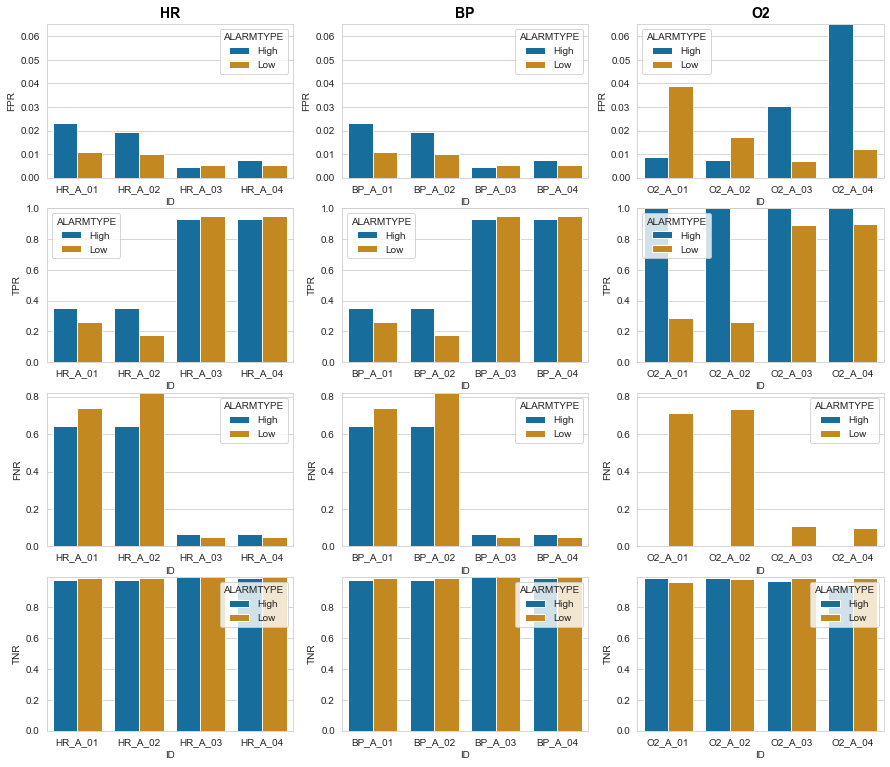

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plotdata = overview.replace( ['_H', '_L'], ['', ''], regex=True)

fig, axs = plt.subplots(
    4,
    3,
    figsize = (15, 13),
    dpi = 72
    )

fpr_ylimits = [0,max(overview.FPR)]
tpr_ylimits = [0,max(overview.TPR)]
fnr_ylimits = [0,max(overview.FNR)]
tnr_ylimits = [0,max(overview.TNR)]

for i, parameter in enumerate(['HR', 'BP', 'O2']):

    sns.barplot(
        ax = axs[0,i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FPR',
        hue='ALARMTYPE',
        palette = sns.color_palette("colorblind"),
        ci=None)
    axs[0,i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[0,i].set_ylim(fpr_ylimits)

    sns.barplot(
        ax = axs[1,i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TPR',
        hue='ALARMTYPE',
        palette = sns.color_palette("colorblind"),
        ci=None)
    # axs[1,i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[1,i].set_ylim(tpr_ylimits)

    sns.barplot(
        ax = axs[2,i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FNR',
        hue='ALARMTYPE',
        palette = sns.color_palette("colorblind"),
        ci=None)
    # axs[1,i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[2,i].set_ylim(fnr_ylimits)

    sns.barplot(
        ax = axs[3,i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TNR',
        hue='ALARMTYPE',
        palette = sns.color_palette("colorblind"),
        ci=None)
    # axs[1,i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[3,i].set_ylim(tnr_ylimits)

plt.show(fig)

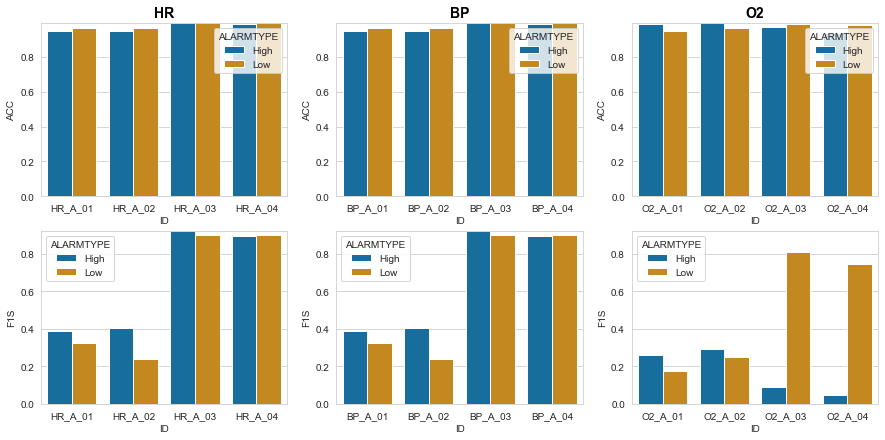

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plotdata = overview.replace( ['_H', '_L'], ['', ''], regex=True)

fig, axs = plt.subplots(
    2,
    3,
    figsize = (15, 7),
    dpi = 72
    )

acc_ylimits = [0,max(overview.ACC)]
f1s_ylimits = [0,max(overview.F1S)]

for i, parameter in enumerate(['HR', 'BP', 'O2']):

    sns.barplot(
        ax = axs[0,i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='ACC',
        hue='ALARMTYPE',
        palette = sns.color_palette("colorblind"))
    axs[0,i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[0,i].set_ylim(acc_ylimits)

    sns.barplot(
        ax = axs[1,i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='F1S',
        hue='ALARMTYPE',
        palette = sns.color_palette("colorblind"))
    # axs[1,i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[1,i].set_ylim(f1s_ylimits)

plt.show(fig)

## Comparison for selected Chunk

In [42]:
selected_chunkid = '200347.0_220045.0_2116-06-05 15:02:00'
selected_iteration = 11

In [43]:
# 01 - ARIMA - Steady Train Size 12
# Confusion matrix for selected chunk
confusion_matrix_per_chunk_01_arima_steady_12_hr[
    confusion_matrix_per_chunk_01_arima_steady_12_hr.CHUNKID == selected_chunkid]

,CHUNKID,ALARMTYPE,TP,FN,FP,TN
280,200347.0_220045.0_2116-06-05 15:02:00,High,5,4,1,364
281,200347.0_220045.0_2116-06-05 15:02:00,Low,0,0,0,374


In [44]:
# 01 - ARIMA - Steady Train Size 12
# Confusion matrix for selected iteration for selected chunk
confusion_matrices_per_chunk_01_arima_steady_12_hr[
    (confusion_matrices_per_chunk_01_arima_steady_12_hr.CHUNKID == selected_chunkid) &
    (confusion_matrices_per_chunk_01_arima_steady_12_hr.ITERATION == selected_iteration)
    ]

,CHUNKID,ITERATION,ALARMTYPE,TP,FN,FP,TN
0,200347.0_220045.0_2116-06-05 15:02:00,11,High,0,0,0,1
1,200347.0_220045.0_2116-06-05 15:02:00,11,Low,0,0,0,1


In [45]:
# 02 - ARIMA - Expanding TRAIN Size
# Confusion matrix for selected chunk
confusion_matrix_per_chunk_02_arima_expanding_12_hr[
    confusion_matrix_per_chunk_02_arima_expanding_12_hr.CHUNKID == selected_chunkid]

,CHUNKID,ALARMTYPE,TP,FN,FP,TN
280,200347.0_220045.0_2116-06-05 15:02:00,High,7,2,0,365
281,200347.0_220045.0_2116-06-05 15:02:00,Low,0,0,0,374


In [46]:
# 02 - ARIMA - Expanding TRAIN Size
# Confusion matrix for selected iteration for selected chunk
confusion_matrices_per_chunk_02_arima_expanding_12_hr[
    (confusion_matrices_per_chunk_02_arima_expanding_12_hr.CHUNKID == selected_chunkid) &
    (confusion_matrices_per_chunk_02_arima_expanding_12_hr.ITERATION == selected_iteration)
    ]

,CHUNKID,ITERATION,ALARMTYPE,TP,FN,FP,TN
0,200347.0_220045.0_2116-06-05 15:02:00,11,High,0,0,0,1
1,200347.0_220045.0_2116-06-05 15:02:00,11,Low,0,0,0,1
